<h2><center> <span style = "font-family: Babas; font-size: 2em;"> Anomaly Detection in Credit Card Transactions </span> </center></h2>
<h4><center> <span style = "font-family: Babas; font-size: 2em;"> Sugata Ghosh </span> </center></h4>

**In this notebook, we consider [an imbalanced dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) of [credit card frauds](https://en.wikipedia.org/wiki/Credit_card_fraud) (with the target labels being *authentic* and *fraudulent*) and build an [anomaly detection](https://en.wikipedia.org/wiki/Anomaly_detection) system to identify transactions that are, in some sense, different from the usual, authentic transactions. These observations are flagged as potentially fraudulent and put to further verification.**

- We carry out necessary feature extraction and feature transformation.
- As the anomaly detection algorithm suffers from high-dimensional data, we figure out the most relevant features separating the target classes, and use only those in the modeling purpose.
- Based on the training data, we fit a [**multivariate normal distribution**](https://en.wikipedia.org/wiki/Multivariate_normal_distribution).
- Given a new transaction, if the corresponding density value of the fitted distribution is lower than a pre-specified threshold, then we flag the transaction as fraudulent.
- In this notebook, we focus more on the true positive class (the class of fraudulent transactions) than the true negative class (the class of authentic transactions). This is because a false negative (the algorithm predicts a fraudulent transaction as authentic) is far more dangerous than a false positive (the algorithm predicts an authentic transaction as fraudulent, which can always be cross-verified). For this reason, we use [**$F_2$-score**](https://en.wikipedia.org/wiki/F-score) as the [**evaluation metric**](https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers).
- The choice of the threshold is optimised by iterating over a pre-specified set of values, predicting on the validation set, and evaluating the predictions by means of the $F_2$-score.
- In this work, the optimal threshold value comes out to be $0.009^9 \approx 3.87 \times 10^{-19}$.
- The corresponding $F_2$-score for predictions on the validation set is $0.834671$, which is an optimistic projection due to the threshold tuning over the validation set.
- Applying the same model on the test set, we get predictions with an $F_2$-score of $0.816492$.

### Contents

- **Introduction**
- **Train-Validation-Test Split**
- **Feature Engineering**
- **Feature Selection**
- **Implementing Anomaly Detection**
- **Threshold Tuning on Validation Set**
- **Prediction and Evaluation on Test Set**
- **Conclusion**
- **Acknowledgements**
- **References**

### Importing libraries

In [1]:
# File system manangement
import time, psutil, os, gc

# Mathematical functions
import math

# Data manipulation
import numpy as np
import pandas as pd

# Plotting and visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_theme()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Train-test split
from sklearn.model_selection import train_test_split

# Progress bar for loop
from tqdm.contrib import itertools

### Runtime and memory usage

In [2]:
# Recording the starting time, complemented with a stopping time check in the end to compute process runtime
start = time.time()

# Class representing the OS process and having memory_info() method to compute process memory usage
process = psutil.Process(os.getpid())

# Introduction

- **Anomaly Detection**
- **Data**
- **Project Objective**
- **Evaluation Metric**

## Anomaly Detection

In [**statistics**](https://en.wikipedia.org/wiki/Statistics) and [**data analysis**](https://en.wikipedia.org/wiki/Data_analysis), an [**anomaly**](https://en.wikipedia.org/wiki/Anomaly) or [**outlier**](https://en.wikipedia.org/wiki/Outlier) refers to a rare observation which deviates significantly from the majority of the data and does not conform to a well-defined notion of normal behaviour. It is possible that such observations may have been generated by a different mechanism or appear inconsistent with the remainder of the dataset. The process of identifying such observations is generally referred to as anomaly detection. In recent days, [**machine learning**](https://en.wikipedia.org/wiki/Machine_learning) is progressively being employed to automate the process of anomaly detection through [**supervised learning**](https://en.wikipedia.org/wiki/Supervised_learning) (when observations are [**labeled**](https://en.wikipedia.org/wiki/Labeled_data) as *normal* or *anomalous*), [**semi-supervised learning**](https://en.wikipedia.org/wiki/Semi-supervised_learning) (when only a small fraction of observations are labeled) and [**unsupervised learning**](https://en.wikipedia.org/wiki/Unsupervised_learning) (when observations are not labeled). Anomaly detection is particularly suitable in the following setup:

- Anomalies are very rare in the dataset
- The features of anomalous observations differ significantly from those of normal observations
- Anomalies may result for different (potentially new) reasons

Anomaly detection can be very useful in credit card fraud detection. Fraudulent transactions are rare compared to authentic transactions. Also, the methods through which fraudulent transactions occur keep evolving, as the old ways get flagged by existing fraud detection systems. In this notebook, we shall develop a basic anomaly detection system that flags transactions with feature values deviating significantly from those of authentic transactions.

## Data

Source: **https://www.kaggle.com/mlg-ulb/creditcardfraud**

The dataset contains information on the transactions made using credit cards by European cardholders, in two particular days of September $2013$. It presents a total of $284807$ transactions, of which $492$ were fraudulent. Clearly, the dataset is highly imbalanced, the positive class (fraudulent transactions) accounting for only $0.173\%$ of all transactions. The columns in the dataset are as follows:

- **Time:** The time (in seconds) elapsed between the transaction and the very first transaction
- **V1 to V28:** Obtained from principle component analysis (PCA) transformation on original features that are not available due to confidentiality
- **Amount:** The amount of the transaction
- **Class:** The status of the transaction with respect to authenticity. The class of an authentic (resp. fraudulent) transaction is taken to be $0$ (resp. $1$)

In [3]:
# Loading the data
data = pd.read_csv('../input/creditcardfraud/creditcard.csv')
print(pd.Series({"Memory usage": "{:.2f} MB".format(data.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data.shape)}).to_string())
data.head()

Memory usage         67.36 MB
Dataset shape    (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Project Objective

The objective of the project is to detect anomalies in credit card transactions. To be prcise, given the data on `Time`, `Amount` and transformed features `V1` to `V28`, our goal is to fit a [**probability distribution**](https://en.wikipedia.org/wiki/Probability_distribution) based on authentic transactions, and then use it to correctly identify a new transaction as authentic or fraudulent. Note that the target variable plays no role in constructing the probability distribution.

## Evaluation Metric

Any prediction about a binary categorical target variable falls into one of the four categories:
- **True Positive:** The classification model correctly predicts the output to be positive
- **True Negative:** The classification model correctly predicts the output to be negative
- **False Positive:** The classification model incorrectly predicts the output to be positive
- **False Negative:** The classification model incorrectly predicts the output to be negative

Let **TP**, **TN**, **FP** and **FN** respectively denote the number of **true positives**, **true negatives**, **false positives** and **false negatives** among the predictions made by a particular classification model. Below we give the definitions of some evaluation metrics based on these four quantities.

\begin{align*}
&\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Number of total predictions}} = \frac{TP + TN}{TP + TN + FP + FN}\\\\
&\text{Precision} = \frac{\text{Number of true positive predictions}}{\text{Number of total positive predictions}} = \frac{TP}{TP + FP}\\\\
&\text{Recall} = \frac{\text{Number of true positive predictions}}{\text{Number of total positive cases}} = \frac{TP}{TP + FN}\\\\
&\text{Fowlkes-Mallows index (FM)} = \text{Geometric mean of Precision and Recall} = \sqrt{\text{Precision} \times \text{Recall}}\\\\
&F_1\text{-Score} = \text{Harmonic mean of Precision and Recall} = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}\\\\
&F_{\beta}\text{-score} = \frac{\left(1 + \beta^2\right) \times \text{Precision} \times \text{Recall}}{\left(\beta^2 \times \text{Precision}\right) + \text{Recall}} = \frac{\left(1 + \beta^2\right) \times TP}{\left(1 + \beta^2\right) \times TP + \beta^2 \times FN + FP},
\end{align*}

where $\beta$ is a positive factor, chosen such that Recall is $\beta$ times as important as Precision in the analysis. Popular choices of $\beta$ are $0.5$, $1$ and $2$.

\begin{align*}
&\text{Matthews Correlation Coefficient (MCC)} = \frac{\left(TP \times TN\right) - \left(FP \times FN\right)}{\sqrt{\left(TP + FP\right) \times \left(TP + FN\right) \times \left(TN + FP\right) \times \left(TN + FN\right)}}.
\end{align*}

Unlike the previous metrics, [**MCC**](https://en.wikipedia.org/wiki/Phi_coefficient) varies from $-1$ (worst case scenario) to $1$ (best case scenario: perfect prediction). Among the discussed metrics, some good choices to evaluate models, in particular for imbalanced datasets, are **MCC** and [**$F_1$-score**](https://en.wikipedia.org/wiki/F-score), while [**Precision and Recall**](https://en.wikipedia.org/wiki/Precision_and_recall) also give useful information. We shall not give much importance to the [**Accuracy**](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification) metric in this project as it produces misleading conclusions when the classes are not balanced. In the problem at hand, false negative (a fraudulent transaction being classified as authentic) is more dangerous than false positive (an authentic transaction being classified as fraudulent). In the former case, the fraudster can cause further financial damage. In the latter case, the bank can cross-verify the authenticity of the transaction from the card-user after taking necessary steps to secure the card. Considering this fact, we employ $F_2$-score to tune threshold parameter and to select features in the present work. In terms of **TP**, **TN**, **FP**, and **FN**, it is given by

$$ F_2\text{-score} = \frac{5 \times TP}{5 \times TP + 4 \times FN + FP}. $$

All of the mentioned metrics are reported for both the validation set and the test set.

# Train-Validation-Test Split

In [4]:
# Splitting the data by target class
data_0, data_1 = data[data['Class'] == 0], data[data['Class'] == 1]

# Feature-target split
X_0, y_0 = data_0.drop('Class', axis = 1), data_0['Class']
X_1, y_1 = data_1.drop('Class', axis = 1), data_1['Class']

# Splitting the authentic class and constructing the training set
X_train, X_test, y_train, y_test = train_test_split(X_0, y_0, test_size = 0.2, random_state = 40)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 40)
data_val_1, data_test_1 = pd.concat([X_val, y_val], axis = 1), pd.concat([X_test, y_test], axis = 1)

# Splitting the fraudulent class
X_val, X_test, y_val, y_test = train_test_split(X_1, y_1, test_size = 0.5, random_state = 40)
data_val_2, data_test_2 = pd.concat([X_val, y_val], axis = 1), pd.concat([X_test, y_test], axis = 1)

# Merging data to construct the validation set and the test set
data_val, data_test = pd.concat([data_val_1, data_val_2], axis = 0), pd.concat([data_test_1, data_test_2], axis = 0)
X_val, y_val = data_val.drop('Class', axis = 1), data_val['Class']
X_test, y_test = data_test.drop('Class', axis = 1), data_test['Class']

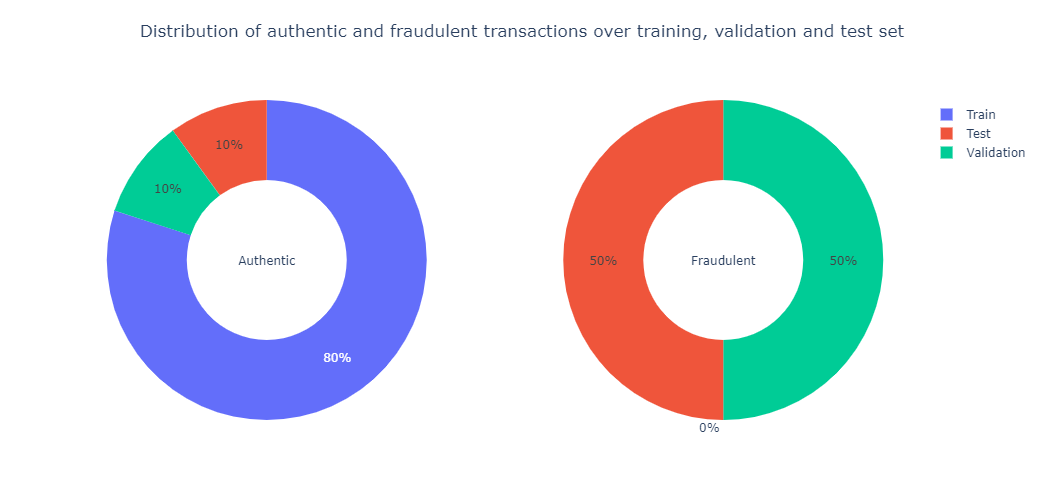

In [5]:
# Distribution of authentic and fraudulent transactions over training, validation and test set
labels = ['Train', 'Validation', 'Test']
values_0 = [len(y_train[y_train == 0]), len(y_val[y_val == 0]), len(y_test[y_test == 0])]
values_1 = [len(y_train[y_train == 1]), len(y_val[y_val == 1]), len(y_test[y_test == 1])]
fig = make_subplots(rows = 1, cols = 2, specs = [[{'type': 'domain'}, {'type': 'domain'}]])
fig.add_trace(go.Pie(values = values_0, labels = labels, hole = 0.5, textinfo = 'percent', title = "Authentic"),
              row = 1, col = 1)
fig.add_trace(go.Pie(values = values_1, labels = labels, hole = 0.5, textinfo = 'percent', title = "Fraudulent"),
              row = 1, col = 2)
text_title = "Distribution of authentic and fraudulent transactions over training, validation and test set"
fig.update_layout(height = 500, width = 800, showlegend = True, title = dict(text = text_title, x = 0.5, y = 0.95)) 
fig.show()

In general, throughout the notebook, we choose the number of bins of a histogram by the [**Freedman-Diaconis rule**](https://en.wikipedia.org/wiki/Freedman%E2%80%93Diaconis_rule), which suggests the optimal number of bins to grow as $k \sim n^{1/3},$ where $n$ is the total number of observations.

In [6]:
# Setting the number of bins
bins_train = math.floor(len(X_train)**(1/3))

# Feature Engineering

## Time

In [7]:
# Decomposing time
for df in [X_train, X_val, X_test]:
    df['Day'], temp = df['Time'] // (24*60*60), df['Time'] % (24*60*60)
    df['Hour'], temp = temp // (60*60), temp % (60*60)
    df['Minute'], df['Second'] = temp // 60, temp % 60
X_train[['Time', 'Day', 'Hour', 'Minute', 'Second']].head()

,Time,Day,Hour,Minute,Second
19594,30401.0,0.0,8.0,26.0,41.0
124712,77397.0,0.0,21.0,29.0,57.0
167920,118964.0,1.0,9.0,2.0,44.0
47377,43191.0,0.0,11.0,59.0,51.0
41731,40804.0,0.0,11.0,20.0,4.0


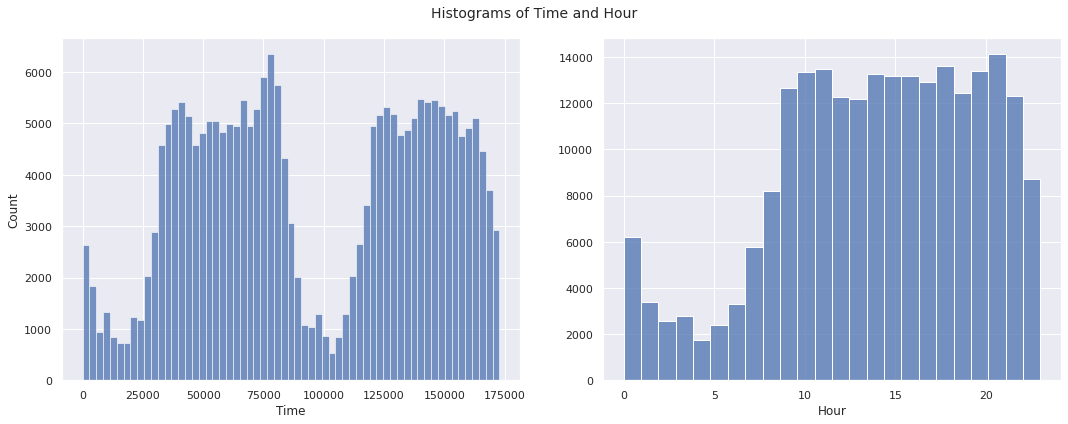

In [8]:
# Visualization
fig, ax = plt.subplots(1, 2, figsize = (15, 6), sharey = False)
sns.histplot(data = X_train, x = 'Time', bins = bins_train, ax = ax[0])
sns.histplot(data = X_train, x = 'Hour', bins = 24, ax = ax[1])
ax[1].set_ylabel(" ")
plt.suptitle("Histograms of Time and Hour", size = 14)
plt.tight_layout()
plt.show()

## Amount

The distribution of `Amount` has extreme positive skewness. We apply the transformation $x \mapsto \log{\left(x + 0.001\right)}$ to this column and form the new column `Amount_transformed`. The positive constant $0.001$ is added to deal with the zero-amount transactions, which leads to $\log{0}$, an undefined quantity.

In [9]:
# Transformation of 'Amount'
for df in [X_train, X_val, X_test]:
    df['Amount_transformed'] = np.log10(df['Amount'] + 0.001)

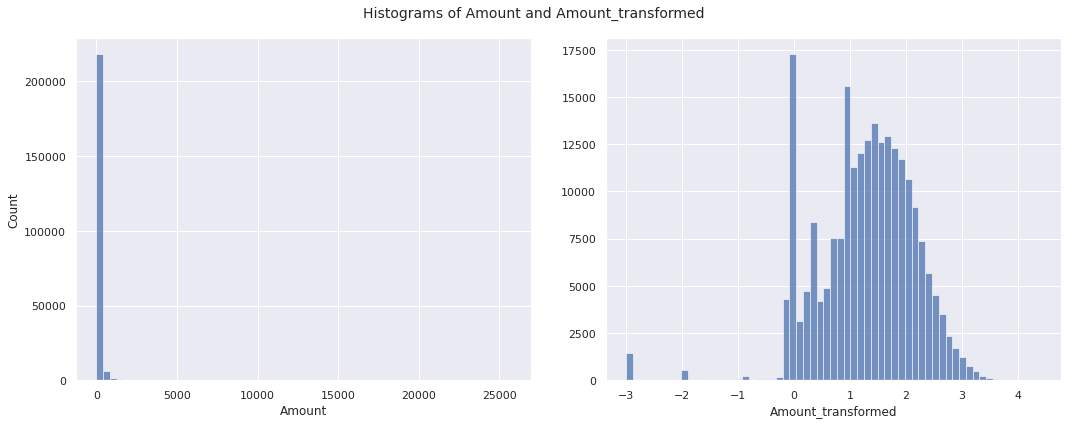

In [10]:
# Visualization
fig, ax = plt.subplots(1, 2, figsize = (15, 6), sharey = False)
sns.histplot(data = X_train, x = 'Amount', bins = bins_train, ax = ax[0])
sns.histplot(data = X_train, x = 'Amount_transformed', bins = bins_train, ax = ax[1])
ax[1].set_ylabel(" ")
plt.suptitle("Histograms of Amount and Amount_transformed", size = 14)
plt.tight_layout()
plt.show()

In [11]:
# Discarding unnecessary columns
for df in [X_train, X_val, X_test]:
    df.drop(['Time', 'Day', 'Minute', 'Second', 'Amount'], axis = 1, inplace = True)

# Feature Selection

From [**Thudumu *et al.* (2020)**](https://doi.org/10.1186/s40537-020-00320-x):

> High dimensionality creates difficulties for anomaly detection because, when the number of attributes or features increase, the amount of data needed to generalize accurately also grows, resulting in data sparsity in which data points are more scattered and isolated. This data sparsity is due to unnecessary variables, or the high noise level of multiple irrelevant attributes, that conceal the true anomalies. This issue is widely acknowledged as the [**curse of dimensionality**](https://en.wikipedia.org/wiki/Curse_of_dimensionality).

In the problem at hand, we have $30$ features. We aim to keep only those which help substantially in discriminating between authentic and fraudulent transactions. More specifically, we compare the distribution of each feature for both the target classes. If a feature has similar distributions for both authentic and fraudulent transactions, then it is not likely to contribute much in the process of classifying a transaction as *authentic* or *fraudulent*. However, if a feature has very different distributions for different target classes, then it plays a far more significant role in the same process. We plot the distributions and select the features exhibiting fairly distinct distributions across the target classes.

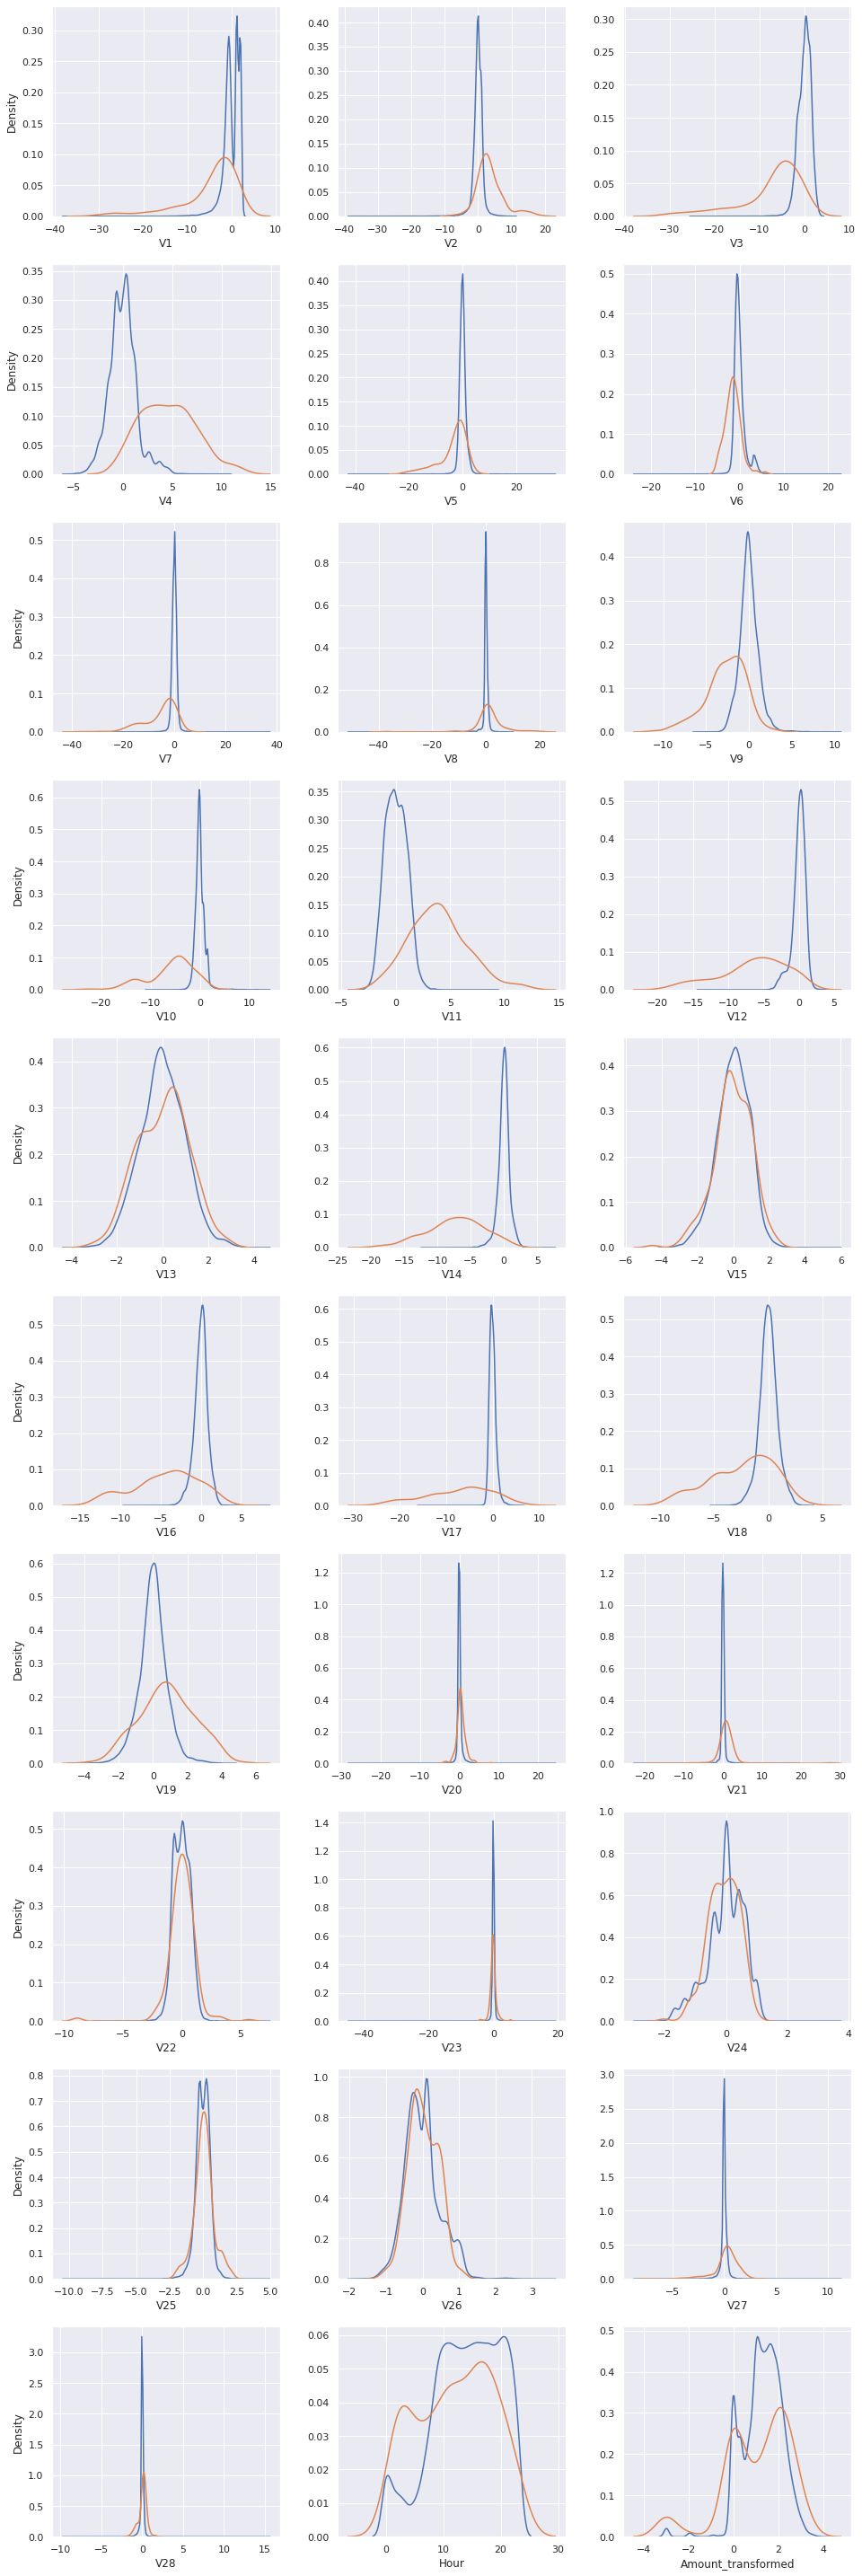

In [12]:
# Comparison of feature distributions for different target classes
data_val = pd.concat([X_val, y_val], axis = 1)
data_val_0, data_val_1 = data_val[data_val['Class'] == 0], data_val[data_val['Class'] == 1]
cols, ncols = list(X_val.columns), 3
nrows = math.ceil(len(cols) / ncols)
fig, ax = plt.subplots(nrows, ncols, figsize = (4.5 * ncols, 4 * nrows))
for i in range(len(cols)):
    sns.kdeplot(data_val_0[cols[i]], ax = ax[i // ncols, i % ncols])
    sns.kdeplot(data_val_1[cols[i]], ax = ax[i // ncols, i % ncols])
    if i % ncols != 0:
        ax[i // ncols, i % ncols].set_ylabel(" ")
plt.tight_layout()
plt.show()

In [13]:
# Feature selection
cols = ['V4', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'Hour']
X_train_fs, X_val_fs, X_test_fs = X_train[cols], X_val[cols], X_test[cols]
X_train_fs.head()

,V4,V11,V12,V14,V16,V17,V18,V19,Hour
19594,-0.706232,2.027925,0.535822,0.250769,0.773615,0.449717,-1.963208,0.613481,8.0
124712,1.474933,-1.154523,0.263527,0.316174,-1.029415,1.030772,-0.438839,0.529080,21.0
167920,4.840766,-2.242431,0.034829,-0.546349,-0.070375,1.033695,0.531801,1.215045,9.0
47377,0.565273,-0.157045,-0.548790,0.419194,0.183518,-0.681323,0.911357,1.318132,11.0
41731,-0.428860,-0.580964,-0.609099,-0.187948,1.226723,0.104368,-0.995711,0.420557,11.0


# Implementing Anomaly Detection

The [**probability density function**](https://en.wikipedia.org/wiki/Probability_density_function) (pdf) of a univariate normal distribution with mean $\mu$ and standard deviation $\sigma$ is given by

$$ f\left(x\right) = \frac{1}{\sigma \sqrt{2\pi}}\,\, \exp\left(-\frac{1}{2}\left(\frac{x - \mu}{\sigma}\right)^2\right),\,\, x \in \mathbb{R};\,\, \mu \in \mathbb{R},\,\, \sigma > 0. $$

In [14]:
# Normal pdf
def normal_density(x, mu, sigma):
    """
    Computes univariate normal probability density function (pdf) with mean mu, standard deviation sigma
    Args:
      x (scalar)    : input observation
      mu (scalar)   : mean
      sigma (scalar): standard deviation (> 0)
    Returns:
      f (scalar): value of the univariate normal pdf
    """
    assert sigma > 0, "Standard deviation must be positive"
    f = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(- (1 / 2) * ((x - mu) / sigma)**2)
    return f

The next function computes the product of such univariate normal densities. This can be seen as the joint pdf of a number of feature variables, each of which has a univariate normal distribution and is statistically independent of the other features.

In [15]:
# Product of normal pdfs
def normal_product(x_vec, mu_vec, sigma_vec):
    """
    Computes product of univariate normal densities
    Args:
      x_vec (array_like, shape (n,))    : vector of input observations
      mu_vec (array_like, shape (n,))   : vector of means
      sigma_vec (array_like, shape (n,)): vector of standard deviations (> 0)
    Returns:
      f (scalar): product of univariate normal densities
    """
    assert min(sigma_vec) > 0, "Standard deviation must be positive"
    assert len(mu_vec) == len(x_vec), "Length of mean vector does not match length of input vector"
    assert len(sigma_vec) == len(x_vec), "Length of standard deviation vector does not match length of input vector"
    f = 1
    for i in range(len(x_vec)):
        f = f * normal_density(x_vec[i], mu_vec[i], sigma_vec[i])
    return f

Next, we compute the vector of means and vector of standard deviations for the features in the training set. These estimates characterize the joint probability density function of the features, which will be used to detect anomalous observations.

In [16]:
# Model fitting
mu_train, sigma_train = X_train_fs.mean(), X_train_fs.std()

In [17]:
# Function to predict anomaly based on probability density threshold
def model_normal(X, epsilon):
    """
    Anomaly detection model
    Args:
      X (DataFrame, shape (m, n)): DataFrame of features
      epsilon (scalar)           : threshold density value (> 0)
    Returns:
      y (array_like, shape (m,)): predicted class labels
    """
    y = []
    for i in X.index:
        prob_density = normal_product(X.loc[i].tolist(), mu_train, sigma_train)
        y.append((prob_density < epsilon).astype(int))
    return y

# Threshold Tuning on Validation Set

First, we construct some functions to compute and display the confusion matrix and to compute the $F_2$-score, given the true labels and the predicted labels of the target.

In [18]:
# Function to compute confusion matrix
def conf_mat(y_test, y_pred):
    """
    Computes confusion matrix
    Args:
      y_test (array_like): true binary (0 or 1) labels
      y_pred (array_like): predicted binary (0 or 1) labels
    Returns:
      confusion_mat (array): A 2D array representing a 2x2 confusion matrix
    """
    y_test, y_pred = list(y_test), list(y_pred)
    count, labels, confusion_mat = len(y_test), [0, 1], np.zeros(shape = (2, 2), dtype = int)
    for i in range(2):
        for j in range(2):
            confusion_mat[i][j] = len([k for k in range(count) if y_test[k] == labels[i] and y_pred[k] == labels[j]])
    return confusion_mat

In [19]:
# Function to print confusion matrix
def conf_mat_heatmap(y_test, y_pred):
    """
    Prints confusion matrix
    Args:
      y_test (array_like): true binary (0 or 1) labels
      y_pred (array_like): predicted binary (0 or 1) labels
    Returns:
      Nothing, prints a heatmap representing a 2x2 confusion matrix
    """
    confusion_mat = conf_mat(y_test, y_pred)
    labels, confusion_mat_df = [0, 1], pd.DataFrame(confusion_mat, range(2), range(2))
    plt.figure(figsize = (6, 4.75))
    sns.heatmap(confusion_mat_df, annot = True, annot_kws = {"size": 16}, fmt = 'd')
    plt.xticks([0.5, 1.5], labels, rotation = 'horizontal')
    plt.yticks([0.5, 1.5], labels, rotation = 'horizontal')
    plt.xlabel("Predicted label", fontsize = 14)
    plt.ylabel("True label", fontsize = 14)
    plt.title("Confusion Matrix", fontsize = 14)
    plt.grid(False)
    plt.show()

In [20]:
# Function to compute and return f2_score
def f2_score(y_test, y_pred):
    """
    Computes accuracy, given true and predicted binary (0 or 1) labels
    Args:
      y_test (array_like): true binary (0 or 1) labels
      y_pred (array_like): predicted binary (0 or 1) labels
    Returns:
      f2 (float): accuracy obtained from y_test and y_pred
    """
    confusion_mat = conf_mat(y_test, y_pred)
    tn, fp, fn, tp = confusion_mat[0, 0], confusion_mat[0, 1], confusion_mat[1, 0], confusion_mat[1, 1]
    f2 = (5 * tp) / ((5 * tp) + (4 * fn) + fp)
    return f2

In [21]:
# Tuning the threshold of density value
alpha_list, f2_list, f2_max, alpha_opt, y_val_pred_opt = [], [], 0.0, 0.0, np.zeros(len(y_val))
for alpha, j in itertools.product(np.arange(0.001, 0.051, 0.001), range(1)):
    y_val_pred = model_normal(X_val_fs, epsilon = alpha**X_val_fs.shape[1])
    f2 = f2_score(y_val, y_val_pred)
    alpha_list.append(alpha)
    f2_list.append(f2)
    if f2 > f2_max:
        alpha_opt = alpha
        y_val_pred_opt = y_val_pred
        f2_max = f2

  0%|          | 0/50 [00:00<?, ?it/s]

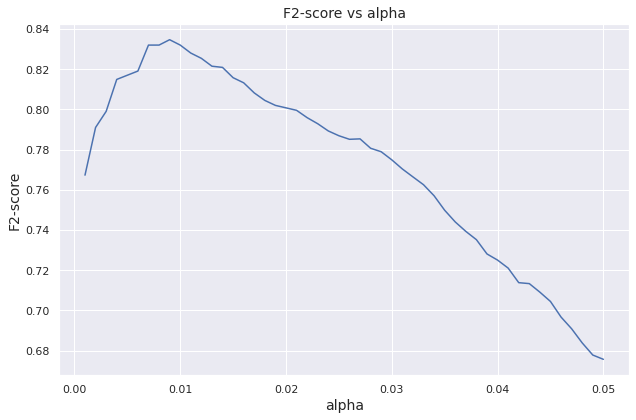

In [22]:
# Plotting F2-score over alpha
plt.figure(figsize = (9, 6))
plt.plot(alpha_list, f2_list)
plt.xlabel("alpha", fontsize = 14)
plt.ylabel("F2-score", fontsize = 14)
plt.title("F2-score vs alpha", fontsize = 14)
plt.tight_layout()
plt.show()

In [23]:
# Tuning summary
print(pd.Series({
    "Optimal alpha": alpha_opt,
    "Optimal F2-score": f2_score(y_val, y_val_pred_opt)
}).to_string())

Optimal alpha       0.009000
Optimal F2-score    0.834671


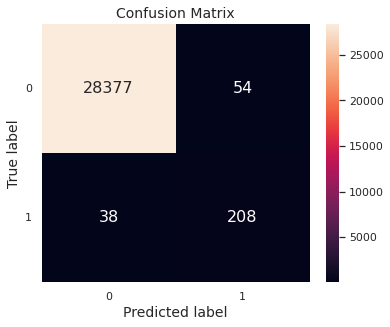

In [24]:
# Confusion matrix for predictions on the validation set
conf_mat_heatmap(y_val, y_val_pred_opt)

# Prediction and Evaluation on Test Set

In [25]:
# Function to compute and print evaluation metrics
def evaluation(y_test, y_pred):
    confusion_mat = conf_mat(y_test, y_pred)
    tn, fp, fn, tp = confusion_mat[0, 0], confusion_mat[0, 1], confusion_mat[1, 0], confusion_mat[1, 1]
    print(pd.Series({
        "Accuracy": (tp + tn) / (tn + fp + fn + tp),
        "Precision": tp / (tp + fp),
        "Recall": tp / (tp + fn),
        "F1-score": (2 * tp) / ((2 * tp) + fn + fp),
        "F2-score": (5 * tp) / ((5 * tp) + (4 * fn) + fp),
        "MCC": ((tp * tn) - (fp * fn)) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    }).to_string())

In [26]:
# Prediction and evaluation on the test set
y_test_normal = model_normal(X_test_fs, epsilon = alpha_opt**X_test_fs.shape[1])
evaluation(y_test, y_test_normal)

Accuracy     0.996687
Precision    0.798419
Recall       0.821138
F1-score     0.809619
F2-score     0.816492
MCC          0.808030


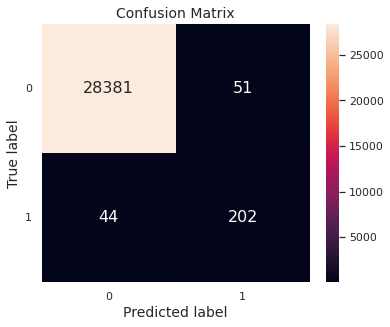

In [27]:
# Confusion matrix for predictions on the test set
conf_mat_heatmap(y_test, y_test_normal)

# Conclusion

To sum up, we observed that the data is heavily imbalanced with fraudulent transaction occuring rarely compared to authentic transactions. Also there are possibilities for fraudulent transactions to occur in completely new ways than before, making it difficult to *train* data on fraudulent transactions. Thus we build an anomaly detection system to find transactions, which are, in some sense, different from the usual observations.

Specifically, we have extracted `Hour` out of the `Time` feature and log-transformed (with a slight shift) the highly skewed `Amount` feature into `Amount_transformed`. Out of the $30$ features (obtained after feature engineering), we have selected $9$ features which have significantly different distributions, for the different target classes: `V4`, `V11`, `V12`, `V14`, `V16`, `V17`, `V18`, `V19` and `Hour`. Based on the training data, we fit a multivariate normal distribution (by estimating the vector of means and the vector of standard deviations, assuming statistical independence among the features, which is a reasonable condition as most of the features in the provided dataset are already [**PCA-engineered**](https://en.wikipedia.org/wiki/Principal_component_analysis)). Given a new transaction, if the corresponding density value of the fitted distribution is lower than a pre-specified threshold, then we flag the transaction as fraudulent. The choice of the threshold is optimised by iterating over a pre-specified set of values, predicting on the validation set, and evaluating the estimates by means of the $F_2$-score.

In this work, the optimal threshold value comes out to be $0.009^9 \approx 3.87 \times 10^{-19}$. The corresponding $F_2$-score for predictions on the validation set is $0.834671$, which is an optimistic projection due to the threshold tuning over the validation set. Applying the same model on the test set, we get predictions with an $F_2$-score of $0.816492$.

# Acknowledgements

- [**Credit Card Fraud Detection**](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) dataset

# References

- [**A comprehensive survey of anomaly detection techniques for high dimensional big data**](https://doi.org/10.1186/s40537-020-00320-x) by **Thudumu, S.**, **Branch, P.**, **Jin, J.**, and **Singh, J.**
- [**Accuracy**](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification)
- [**Anomaly**](https://en.wikipedia.org/wiki/Anomaly)
- [**Anomaly detection**](https://en.wikipedia.org/wiki/Anomaly_detection)
- [**Credit card fraud**](https://en.wikipedia.org/wiki/Credit_card_fraud)
- [**Curse of dimensionality**](https://en.wikipedia.org/wiki/Curse_of_dimensionality)
- [**Evaluation of binary classifiers**](https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers)
- [**$F$-score**](https://en.wikipedia.org/wiki/F-score)
- [**Freedman-Diaconis rule**](https://en.wikipedia.org/wiki/Freedman%E2%80%93Diaconis_rule)
- [**Joint probability distribution**](https://en.wikipedia.org/wiki/Joint_probability_distribution)
- [**Labeled data**](https://en.wikipedia.org/wiki/Labeled_data)
- [**Lebesgue integration**](https://en.wikipedia.org/wiki/Lebesgue_integration)
- [**Machine learning**](https://en.wikipedia.org/wiki/Machine_learning)
- [**Multivariate normal distribution**](https://en.wikipedia.org/wiki/Multivariate_normal_distribution)
- [**Normal distribution**](https://en.wikipedia.org/wiki/Normal_distribution)
- [**Outlier**](https://en.wikipedia.org/wiki/Outlier)
- [**Phi coefficient**](https://en.wikipedia.org/wiki/Phi_coefficient)
- [**Precision and recall**](https://en.wikipedia.org/wiki/Precision_and_recall)
- [**Principal component analysis**](https://en.wikipedia.org/wiki/Principal_component_analysis)
- [**Probability density function**](https://en.wikipedia.org/wiki/Probability_density_function)
- [**Probability distribution**](https://en.wikipedia.org/wiki/Probability_distribution)
- [**Real-valued function**](https://en.wikipedia.org/wiki/Real-valued_function)
- [**Semi-supervised learning**](https://en.wikipedia.org/wiki/Semi-supervised_learning)
- [**Statistics**](https://en.wikipedia.org/wiki/Statistics)
- [**Supervised learning**](https://en.wikipedia.org/wiki/Supervised_learning)
- [**Unsupervised learning**](https://en.wikipedia.org/wiki/Unsupervised_learning)

In [28]:
# Runtime and memory usage
stop = time.time()
print(pd.Series({"Process runtime": "{:.2f} seconds".format(float(stop - start)),
                 "Process memory usage": "{:.2f} MB".format(float(process.memory_info()[0]/(1024*1024)))}).to_string())

Process runtime         299.94 seconds
Process memory usage         676.83 MB
